# Семинар 16
## _SGD update_

Д.В. Яценко

In [1]:
import torch
import os
import random
import time
import shutil
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss
from torch.optim import lr_scheduler,SGD,Adam,AdamW,Adagrad,RMSprop

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Подготовим датасет

In [2]:
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz

--2023-05-20 18:10:12--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz
Распознаётся www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)… 131.227.80.48
Подключение к www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 13596287 (13M) [application/x-gzip]
Сохранение в: «EnglishHnd.tgz.2»

EnglishHnd.tgz.2    100%[===================>]  12,97M  8,34MB/s    за 1,6s    

2023-05-20 18:10:14 (8,34 MB/s) - «EnglishHnd.tgz.2» сохранён [13596287/13596287]



In [3]:
!tar xzf EnglishHnd.tgz

In [4]:
!rm English/Hnd/Img/all.txt~ 

разделяем на train и test

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    source_files = [f for f in os.listdir(SOURCE) if os.path.getsize(os.path.join(SOURCE, f)) > 0]
    random.shuffle(source_files)
    total = len(source_files)
    to_training = source_files[0: int(total * SPLIT_SIZE)]
    to_test = source_files[int(total * SPLIT_SIZE):]
    for file_name in to_training:
        full_file_name = os.path.join(SOURCE, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, TRAINING)
    for file_name in to_test:
        full_file_name = os.path.join(SOURCE, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, TESTING)

In [6]:
!rm -rf chars
ls="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
dirs=list(os.listdir("English/Hnd/Img/"))
dirs.sort()
for i in range(10):
  os.makedirs("chars/train/"+ls[i])
  os.makedirs("chars/val/"+ls[i])
  split_data("English/Hnd/Img/"+dirs[i],"chars/train/"+ls[i],"chars/val/"+ls[i],0.7)

### Преобразуем изображения к нужному виду и создаем объект датасет (2)

In [7]:
import PIL
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(32,interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(32),
        transforms.Grayscale(),
        transforms.RandomInvert(p=1),
        # transforms.RandomRotation((-20,20),interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize(32,interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(32),
        transforms.Grayscale(),
        transforms.RandomInvert(p=1),
        transforms.ToTensor(),
    ]),
}

data_dir = 'chars/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=20)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/lib64/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### визуализируем датасет

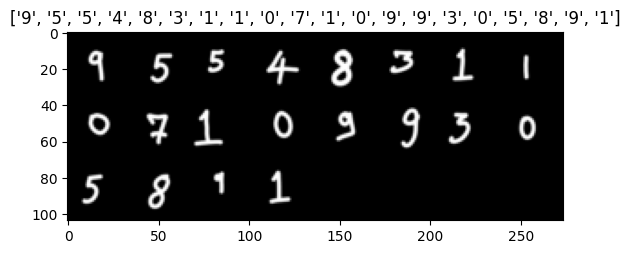

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Функция обучения сети

In [9]:
def train_model(model, criterion, optimizer, num_epochs=35):
    since = time.time()
    hist_acc={"train":[],"val":[]}
    best_acc = 0.0
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if(phase == "train"): 
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            hist_acc[phase].append(epoch_acc.cpu().data)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.cpu().data
        clear_output(True)
        fig=plt.figure()
        plt.plot(hist_acc["train"],label="Acc train "+type(optimizer).__name__)
        plt.plot(hist_acc["val"],label="Acc val "+ type(optimizer).__name__)
        plt.legend()
        plt.show()        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc)) 
    model.eval()
    return best_acc,time_elapsed,fig

### Модель сети (1) 

In [10]:
class ImgNet(Module):
    def __init__(self, num_inputs, num_classes):    
        super(self.__class__,self).__init__()
        self.flat = Flatten()
        self.l1=Sequential(Linear(num_inputs,3*num_classes),ELU())
        self.l2=Sequential(Linear(3*num_classes,2*num_classes),ELU())
        self.l3=Sequential(Linear(2*num_classes,num_classes))
        # self.l1=Sequential(Linear(num_inputs,3*num_classes),BatchNorm1d(3*num_classes),ELU(), Dropout(0.2))
        # self.l2=Sequential(Linear(3*num_classes,2*num_classes),BatchNorm1d(2*num_classes),ELU(),Dropout(0.2))
        # self.l3=Sequential(Linear(2*num_classes,num_classes),BatchNorm1d(num_classes),Dropout(0.2)) 
    def forward(self, x):
        x=self.flat(x)
        return self.l3(self.l2(self.l1(x)))

задаем оптимизатор и функцию потерь

In [11]:
model_ft = ImgNet(32*32,len(ls)).to(device)
criterion = CrossEntropyLoss()  # выходная функция активации уже встроена! https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
optimizer_ft = SGD(model_ft.parameters(), lr=0.001)  #SGD,  SGD(momentum=0.9), Adagrad, RMSprop Adam 

обучаем сеть и сохраняем график обучения для последующего анализа

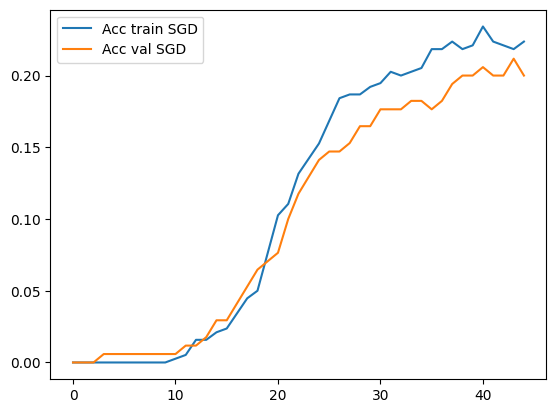

Training complete in 1m 33s
Best val Acc: 0.211765


In [12]:
start_time = time.time()
best_acc,time_elapsed,fig = train_model(model_ft, criterion, optimizer_ft,num_epochs=45)
fig.savefig("acc_{}_{}.png".format(round(float(best_acc),2),type(optimizer_ft).__name__))

## Собственная реализация оптимизаторов

### SGD
$x_{t+1}=x_t-\alpha \nabla f(x_t)$

In [13]:
class MySGD():
    def __init__(self, params, lr=0.001):
        self.params=[]
        for p in params: self.params.append(p)
        self.lr=lr
    def step(self):
        for p in self.params:
            if p.grad is None: continue
            p.data.add_(-self.lr * p.grad.data)

    def zero_grad(self):
        for p in self.params:
            if p.grad is None: continue
            p.grad.data.zero_()

### SGD with momentum
$
 v_{t+1}=\rho v_t + \nabla f(x_t) \\
 x_{t+1} = x_t - \alpha v_{t+1}
$


In [14]:
class MySGDwMomentum():
    def __init__(self, params, lr=0.001, rho=0.9):
        self.rho=rho
        self.v=[]
        self.params=[]
        for p in params:
            self.params.append(p)
            self.v.append(torch.zeros_like(p.data))
        self.lr=lr
    def step(self):
        for p,v in zip(self.params,self.v):
            if p.grad is None: continue
            v_ = self.rho * v.data + p.grad.data
            v.data = v_
            p.data.add_(-self.lr * v_)

    def zero_grad(self):
        for p in self.params:
            if p.grad is None: continue
            p.grad.data.zero_()

### Adagrad
$
 \text{cache}_{t+1} = \text{cache}_t + (\nabla f(x_t))^2 \\
 x_{t+1} = x_t - \alpha \frac {(\nabla f(x_t)}{\text{cache}_{t+1} + \varepsilon}
$

In [15]:
class MyAdagrad():
    def __init__(self, params, lr=0.001):
        self.cache=[]
        self.params=[]
        for p in params:
            self.params.append(p)
            self.cache.append(torch.zeros_like(p.data))
        self.lr=lr
    def step(self):
        for p,cache in zip(self.params,self.cache):
            if p.grad is None: continue
            cache.data.add_(p.grad.data**2)
            p.data.add_(-self.lr*p.grad.data/(cache.data+0.00001))

    def zero_grad(self):
        for p in self.params:
            if p.grad is None: continue
            p.grad.data.zero_()

### RMSProp
$
 \text{cache}_{t+1} = \beta \text{cache}_t + (1-\beta)(\nabla f(x_t))^2 \\
 x_{t+1} = x_t - \alpha \frac {(\nabla f(x_t)}{\text{cache}_{t+1} + \varepsilon}
$

In [16]:
class MyRMSprop():
    def __init__(self, params, lr=0.001,b=0.9):
        self.b=b
        self.cache=[]
        self.params=[]
        for p in params:
            self.params.append(p)
            self.cache.append(torch.zeros_like(p.data))
        self.lr=lr
    def step(self):
        for p,cache in zip(self.params,self.cache):
            if p.grad is None: continue
            cache.data.mul_(self.b)
            cache.data.add_((1-self.b)*p.grad.data**2)
            p.data.add_(-self.lr*p.grad.data/(cache.data+0.00001))

    def zero_grad(self):
        for p in self.params:
            if p.grad is None: continue
            p.grad.data.zero_()

### Adam
$
 v_{t+1} = \gamma v_t + (1-\gamma) \nabla f(x_t) \\
 \text{cache}_{t+1} = \beta \text{cache}_t + (1-\beta)(\nabla f(x_t))^2 \\
 x_{t+1} = x_t - \alpha \frac {v_{t+1}}{\text{cache}_{t+1} + \varepsilon}
$

In [17]:
class MyAdam():
    def __init__(self, params, lr=0.001,b=0.9,gamma=0.99):
        self.b = b
        self.gamma = gamma
        self.v = []
        self.cache = []
        self.params = []
        for p in params:
            self.params.append(p)
            self.cache.append(torch.zeros_like(p.data))
            self.v.append(torch.zeros_like(p.data))
        self.lr=lr
    def step(self):
        for p,v,cache in zip(self.params,self.v,self.cache):
            if p.grad is None: continue
            v_= self.gamma * v.data + (1 - self.gamma) * p.grad.data
            v.data=v_
            cache.data.mul_(self.b)
            cache.data.add_((1-self.b)*p.grad.data**2)
            p.data.add_(-self.lr * v_ / (cache.data+0.00001))

    def zero_grad(self):
        for p in self.params:
            if p.grad is None: continue
            p.grad.data.zero_()

## Нормализация 

измените модель сети, добавив батчнорм и дропаут.  перекомментируйте строки в описании модели  (1), и повторите обучение. 

Сравните скорость и качество обучения с предыдущим разом по сохраненным графикам. Обратите внимание также на переобучение.

## Аугментация (обогащение)

раскомментируйте строку transforms.RandomRotation в коде создания датасета (2) и повторите обучение.

Сравните скорость и качество обучения с предыдущим разом по сохраненным графикам. Обратите внимание также на переобучение.